In [21]:
import json
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api

import re

from vit_pytorch import ViT
from torch.optim.lr_scheduler import StepLR

In [22]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

In [23]:
path_to_training = Path("../data/training")
path_to_test = Path("../data/test")

#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [24]:
model = api.load('glove-twitter-100')

In [25]:
model['hello'].shape

(100,)

In [26]:
y_training = []
with open("../data/training_labels.json", "r") as file:
    training_labels = json.load(file)
X_training = []
for transcription_id in training_set:
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)
    
    for utterance in transcription:
        vecs = []
        vecs.append(model[utterance["speaker"].lower()])
        for word in re.split(" |'", utterance["text"]):
            if word.lower() == "<vocalsound>":
                vecs.append(model["vocal"])
                vecs.append(model["sound"])
            elif word.lower() == "<disfmarker>":
                vecs.append(model["marker"])
            elif word.lower() == "<gap>":
                vecs.append(model["gap"])
            elif word.lower() not in model:
                pass
            else:
                vecs.append(model[word.lower()])
        while len(vecs) < 80:
            vecs.append(np.zeros(100))
        if len(vecs) > 80:
            print(len(vecs))

        array = np.array([vecs, vecs, vecs])
        array = array.reshape(3, 80, 100)
        X_training.append(array)
    
    y_training += training_labels[transcription_id]


In [27]:
X_training = np.array(X_training)
y_training = np.array(y_training)

print(X_training.shape)
print(y_training.shape)

(72623, 3, 80, 100)
(72623,)


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# define batch size
batch_size = 16

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(X_train).float().to(device), torch.from_numpy(y_train).long().to(device))
validset = TensorDataset(torch.from_numpy(X_test).float().to(device), torch.from_numpy(y_test).long().to(device))

# create dataloaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(validset, shuffle=True, batch_size=batch_size)

In [50]:
# Training settings

batch_size = 16
epochs = 5
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [93]:
# Create a sample ViT model

v = ViT(
    image_size = 100,
    patch_size = 20,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.05,
    emb_dropout = 0.1,
    channels = 3
)

# Create a ResNet model using ResNet50

from torchvision.models import resnet50, ResNet50_Weights
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(2048, 2)

# Choose the model to train

model = v.to(device)



In [94]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [96]:
# Train the model

losses_train = []
losses_valid = []

f1_train = []
f1_valid = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        TP += ((output.argmax(dim=1) == label) & (label == 1)).float().sum()
        FP += ((output.argmax(dim=1) != label) & (label == 0)).float().sum()
        TN += ((output.argmax(dim=1) == label) & (label == 0)).float().sum()
        FN += ((output.argmax(dim=1) != label) & (label == 1)).float().sum()


    # compute f1 score

    f1_t = (2*TP)/(2*TP + FP + FN)

    losses_train.append(epoch_loss)
    f1_train.append(f1_t)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()

            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

            TP += ((val_output.argmax(dim=1) == label) & (label == 1)).float().sum()
            FP += ((val_output.argmax(dim=1) != label) & (label == 0)).float().sum()
            TN += ((val_output.argmax(dim=1) == label) & (label == 0)).float().sum()
            FN += ((val_output.argmax(dim=1) != label) & (label == 1)).float().sum()

        # compute f1 score

        f1_v = (2*TP)/(2*TP + FP + FN)

        losses_valid.append(epoch_val_loss)
        f1_valid.append(f1_v)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - train_f1: {f1_t:.4f} - val_loss : {epoch_val_loss:.4f} - val_f1: {f1_v:.4f}\n"
    )
    torch.save(model.state_dict(), 'ViT_model.pth')


  0%|          | 0/3632 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3500 - train_f1: 0.3904 - val_loss : 0.3318 - val_f1: 0.4307



  0%|          | 0/3632 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3347 - train_f1: 0.4339 - val_loss : 0.3297 - val_f1: 0.3620



  0%|          | 0/3632 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.3243 - train_f1: 0.4716 - val_loss : 0.3301 - val_f1: 0.4223



  0%|          | 0/3632 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.3134 - train_f1: 0.5059 - val_loss : 0.3335 - val_f1: 0.4626



  0%|          | 0/3632 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.2978 - train_f1: 0.5457 - val_loss : 0.3461 - val_f1: 0.3082



In [97]:
for (i,loss) in enumerate(losses_train):
    loss = loss.cpu().detach().numpy()
    losses_train[i] = loss
for (i,loss) in enumerate(losses_valid):
    loss = loss.cpu().detach().numpy()
    losses_valid[i] = loss

for (i,f1) in enumerate(f1_train):
    f1 = f1.cpu().detach().numpy()
    f1_train[i] = f1
for (i,f1) in enumerate(f1_valid):
    f1 = f1.cpu().detach().numpy()
    f1_valid[i] = f1

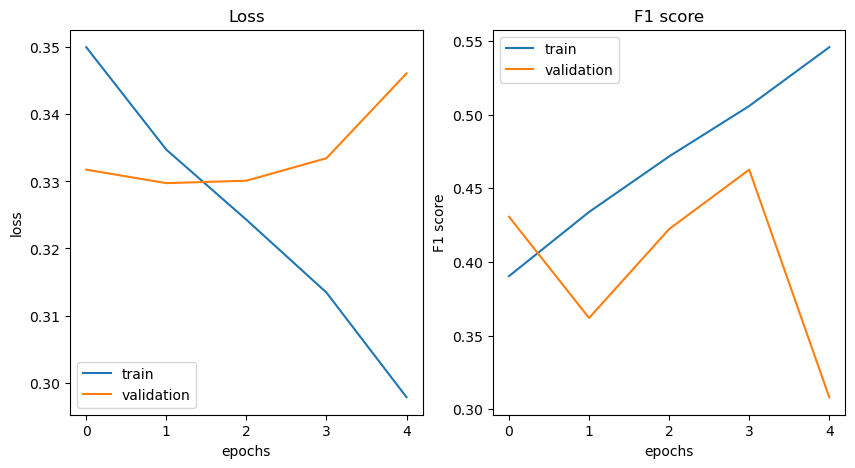

In [98]:
# plot losses and f1 scores

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(losses_train, label="train")
plt.plot(losses_valid, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("F1 score")
plt.plot(f1_train, label="train")
plt.plot(f1_valid, label="validation")
plt.xlabel("epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()
